# VBF veto

**Goal:** To update the background estimate to the new analysis baselines.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import gridspec

from matplotlib import cm
import numpy as np

import os
os.sys.path += ['../gp-for-flows/','../PyATLASstyle/','../../hh4b/hh4b-plots/'] 


from statUtils import getEigenvariations

from gp import *
from flows import *
from bkgPred import *

from hh4b_plots.phys_utils import get_lumi

import cabinetry
cabinetry.set_logging()

import copy
import json
import pathlib

import boost_histogram as bh
import hist
import pyhf
from pyhf.contrib.utils import download

# Let's do ATLAS style plots too!
import matplotlib as mpl
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

from hh4b_plots.colors import *

%load_ext autoreload
%autoreload 2

**note:** I can only compare to Marin's rw for the 4b training models that have the VBF veto!!

**Step 1: I'll compare the (downsampled) 2b SR for**
- data
- iterpolation (GP+flow)

w/ and w/o the vbf veto cut

**Question I'm trying to answer:** Does the VBF veto make the background harder to model?

In [2]:
yr=17

x,y = 124,117
eps = 0.05
r_CR = 45

In [3]:
# d1 = d

In [79]:
cols = ['m_h1','m_h2','ntag','kinematic_region','pass_vbf_sel','dEta_hh','X_hh',
        'event_number','m_hh','pT_h1','pT_h2','eta_h1','eta_h2','phi_h1','phi_h2']

with uproot.open(f'../data/RR/cryptotuples/data{yr}.root') as f:
    arr = f['fullmassplane'].arrays(cols)

In [80]:
from bkgPred import edg_3d, d_cols

In [81]:
mask = getMask(
                arr,
                x,
                y,
                eps,
                r_CR,
                detaCut=0,
                vbfCut=2,
                ntag=2,
                nSplits=100,
                replica=0,
              )

In [86]:
len(mask)

22550026

In [85]:
ak.sum(mask)

25018

In [87]:
df = ak.to_pandas(arr[mask])

In [ ]:
np.cos()

In [107]:
df['dphi_hh'] = np.arccos(np.cos(df['phi_h1']-df['phi_h2']))

In [108]:
len(df)

25018

In [89]:
(df.kinematic_region==0).sum()

4000

Text(0.5, 0, 'X_hh')

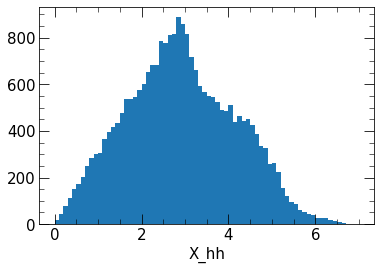

In [95]:
h,e,_ = plt.hist(df.X_hh,70,(0,7))
plt.xlabel('X_hh')

In [99]:
h[:16].sum()

4000.0

`python bkgPred.py -d ../data/RR/cryptotuples/data17.root --ntag 2 --nEvents 100000 --flow_config configs/val1.json --subDir data17-MAY21_2b_0of100_detaCut  --tag orig --nSplits 100 --replica 0`

In [119]:
c = 'val1' 

fc = f'../gp-for-flows/configs/{c}.json'
with open(fc,'r') as cfile:
    hps = json.load(cfile)

L,H,nb,K,lr,beta,p = hps['L'],hps['H'],hps['nb'],hps['K'],hps['lr'],hps['beta'],hps['p']
colTag = '_'.join(hps['cols'])

modelConfig = f'nsf_rq-coupling_{colTag}_lu_{L}_layers_H_{H}_{nb}_blocks_K_{K}_B_3_lr_{lr}_{beta}_p{p}_iter0'
modelDir = f'../gp-for-flows/models/'


In [120]:
modelConfig

'nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_32_1_blocks_K_4_B_3_lr_0.001_1e-06_p0.1_iter0'

In [151]:
hdict1 = {} # GP + flow prediction

subDir1 = 'data17-MAY21_2b_0of100_detaCut'

with open(f'{modelDir}/{subDir1}/{modelConfig}/hists_gp_100k_25bins.json','r') as hfile:
    out = json.load(hfile)

for k in out.keys():
    hdict1[k] = np.array( out[k])

In [122]:
!ls f'{modelDir}/{subDir1}/'

/usr/local/bin/environ: Command not found.
ls: cannot access f../gp-for-flows/models//data17-MAY21_2b_0of100_detaCut/: No such file or directory


In [123]:
gp_df = pd.read_hdf(f'{modelDir}/{subDir1}/df_gp_100k_25bins.h5',key='df')

In [124]:
gp_df.head()

m_h1        m_h2      X_hh      VR_hh      CR_hh  kinematic_region
0   91.460862   82.253075  5.522934  52.709747  56.114447                 3
1   94.831510   80.688074  5.450985  51.647251  55.032337                 3
2  148.648491  100.945207  2.297620  28.649308  28.638554                 1
3  162.305195   99.959496  2.911371  40.230075  39.429922                 2
4  105.022584  123.342531  1.878727  22.873477  25.182233                 1

Text(0.5, 0, 'm_h1')

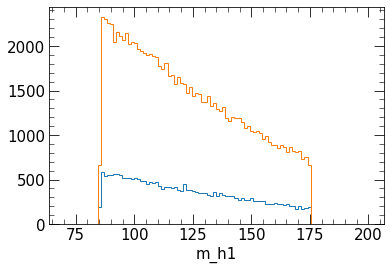

In [125]:
h,e,_ = plt.hist(df.m_h1,100,(70,200),histtype='step')
h,e,_ = plt.hist(gp_df.m_h1,100,(70,200),histtype='step')
plt.xlabel('m_h1')

Text(0.5, 0, 'm_h1')

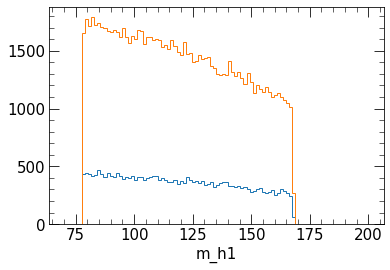

In [126]:
h,e,_ = plt.hist(df.m_h2,100,(70,200),histtype='step')
h,e,_ = plt.hist(gp_df.m_h2,100,(70,200),histtype='step')
plt.xlabel('m_h1')

In [152]:
hdict2 = {} # GP + flow prediction

subDir2 = 'data17-MAY21_2b_0of100_detaCut_ggf'
modelDir2 = f'../gp-for-flows/models/{subDir2}{tag}_2b_detaCut'

with open(f'{modelDir}/{subDir2}/{modelConfig}/hists_gp_100k_25bins.json','r') as hfile:
    out = json.load(hfile)

for k in out.keys():
    hdict2[k] = np.array( out[k])

In [128]:
# hists = []

# for m in tqdm(models):
    
#     # Sample from the NF
#     dfi = m.pred_hh(df_out, dset.scalar)
    
#     # Calculate the new discriminate variables
#     dfi['dEta_hh'] = abs(dfi['eta_h1'] - dfi['eta_h2'])
#     dfi['X_hh'] = Xhh(*dfi[['m_h1','m_h2']].values.T, c1=x, c2=y)
    
#     h_3d = np.histogramdd(dfi[d_cols].values,bins=edg_3d)[0]
#     hists.append(h_3d.flatten())

In [129]:
nSeeds = 25

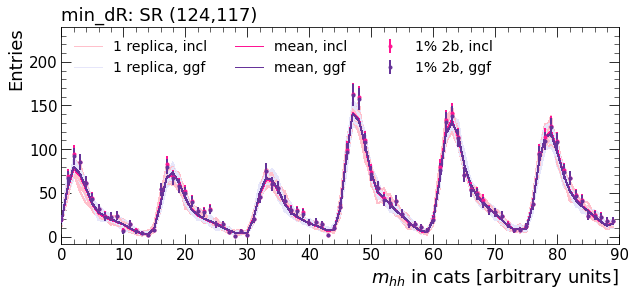

In [153]:
plt.figure(figsize=(10,4))

for i in range(nSeeds):
    
    hi = hdict1[f'X_hh_dEta_hh_m_hh_SR_{i}']
    plt.plot(hi,color='pink',lw=1,
             label='1 replica, incl' if i == 0 else None)
    
    hi = hdict2[f'X_hh_dEta_hh_m_hh_SR_{i}']
    plt.plot(hi,color='lavender',lw=1,
             label='1 replica, ggf' if i == 0 else None)

plt.plot(hdict1[f'X_hh_dEta_hh_m_hh_SR_mean'],color='deeppink',label='mean, incl',lw=1)   
plt.plot(hdict2[f'X_hh_dEta_hh_m_hh_SR_mean'],color='rebeccapurple',label='mean, ggf',lw=1)   

h_2b_1 = np.histogramdd(df[d_cols].values,bins=edg_3d)[0].flatten()
plt.errorbar(range(len(h_2b_1)),h_2b_1,np.sqrt(h_2b_1),color='deeppink',lw=0, 
             elinewidth=2,marker='.',label='1% 2b, incl',zorder=5)


h_2b_2 = np.histogramdd(df.loc[~df.pass_vbf_sel,d_cols].values,bins=edg_3d)[0].flatten()
plt.errorbar(range(len(h_2b_2)),h_2b_2,np.sqrt(h_2b_2),color='rebeccapurple',lw=0, 
             elinewidth=2,marker='.',label='1% 2b, ggf',zorder=5)

plt.xlabel('$m_{hh}$ in cats [arbitrary units]',x=1,ha='right',fontsize=18)
plt.ylabel('Entries',y=1,ha='right',fontsize=18)
plt.title(f'min_dR: SR ({x},{y})',x=0,loc='left')

plt.legend(ncol=3,loc='upper left')
plt.xlim(0,90)
ymin,ymax=plt.ylim()
plt.ylim(ymin,1.3*ymax)

#plt.savefig(f'{figDir}/m_hh_cats_{nSeeds}seeds.pdf',bbox_inches='tight')
plt.show()

In [144]:
np.sum(h_2b_1)

4000.0

In [145]:
np.sum(hdict1[f'X_hh_dEta_hh_m_hh_SR_mean'])

3622.101116990006

In [148]:
hdict1.keys()

dict_keys(['m_hh_SR_mean', 'm_hh_SR_std', 'm_hh_SR_0', 'm_hh_SR_1', 'm_hh_SR_2', 'm_hh_SR_3', 'm_hh_SR_4', 'm_hh_SR_5', 'm_hh_SR_6', 'm_hh_SR_7', 'm_hh_SR_8', 'm_hh_SR_9', 'm_hh_SR_10', 'm_hh_SR_11', 'm_hh_SR_12', 'm_hh_SR_13', 'm_hh_SR_14', 'm_hh_SR_15', 'm_hh_SR_16', 'm_hh_SR_17', 'm_hh_SR_18', 'm_hh_SR_19', 'm_hh_SR_20', 'm_hh_SR_21', 'm_hh_SR_22', 'm_hh_SR_23', 'm_hh_SR_24', 'm_hh_VR_mean', 'm_hh_VR_std', 'm_hh_VR_0', 'm_hh_VR_1', 'm_hh_VR_2', 'm_hh_VR_3', 'm_hh_VR_4', 'm_hh_VR_5', 'm_hh_VR_6', 'm_hh_VR_7', 'm_hh_VR_8', 'm_hh_VR_9', 'm_hh_VR_10', 'm_hh_VR_11', 'm_hh_VR_12', 'm_hh_VR_13', 'm_hh_VR_14', 'm_hh_VR_15', 'm_hh_VR_16', 'm_hh_VR_17', 'm_hh_VR_18', 'm_hh_VR_19', 'm_hh_VR_20', 'm_hh_VR_21', 'm_hh_VR_22', 'm_hh_VR_23', 'm_hh_VR_24', 'm_hh_CR_mean', 'm_hh_CR_std', 'm_hh_CR_0', 'm_hh_CR_1', 'm_hh_CR_2', 'm_hh_CR_3', 'm_hh_CR_4', 'm_hh_CR_5', 'm_hh_CR_6', 'm_hh_CR_7', 'm_hh_CR_8', 'm_hh_CR_9', 'm_hh_CR_10', 'm_hh_CR_11', 'm_hh_CR_12', 'm_hh_CR_13', 'm_hh_CR_14', 'm_hh_CR_15', 'm

WARNING - matplotlib.font_manager - findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.


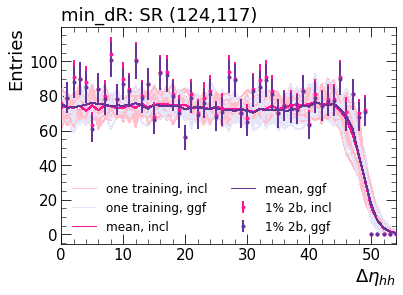

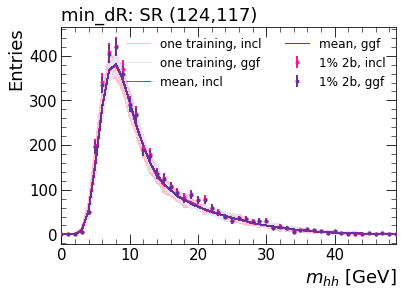

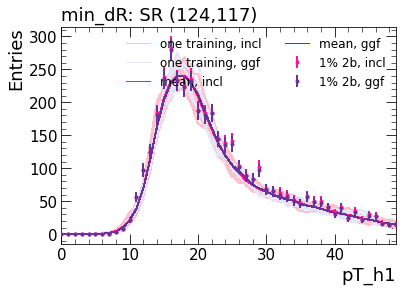

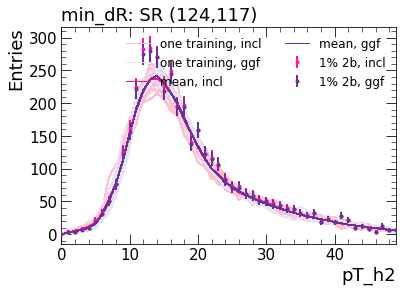

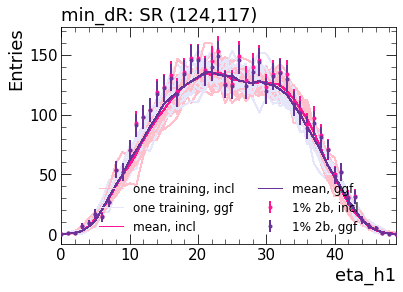

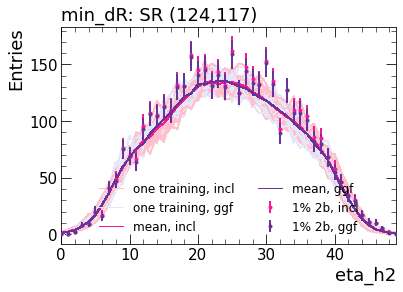

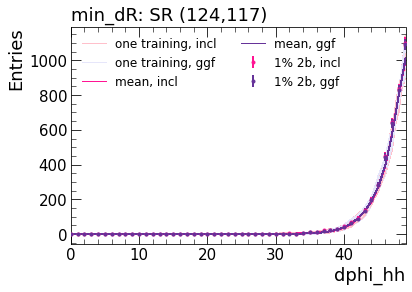

In [162]:
for c, nb, r, xl in zip(['dEta_hh','m_hh','pT_h1','pT_h2','eta_h1','eta_h2','dphi_hh'],
                        [55]+[50]*6,
                        [(0,1.65),(200,1200),(0, 400), (0, 400), (-3, 3), (-3, 3), (-0.5, np.pi)],
                        ['$\Delta \eta_{hh}$', '$m_{hh}$ [GeV]','pT_h1','pT_h2','eta_h1','eta_h2','dphi_hh']):

    plt.figure()
    
    for i in range(nSeeds):

        hi = hdict1[f'{c}_SR_{i}']
        plt.plot(hi,color='pink',lw=1,
                 label='one training, incl' if i == 0 else None)

        hi = hdict2[f'{c}_SR_{i}']
        plt.plot(hi,color='lavender',lw=1,
                 label='one training, ggf' if i == 0 else None)


        
    plt.plot(hdict1[f'{c}_SR_mean'],color='deeppink',label='mean, incl',lw=1)   
    plt.plot(hdict2[f'{c}_SR_mean'],color='rebeccapurple',label='mean, ggf',lw=1)   

    h_2b_1 = np.histogram(df.loc[df.X_hh < 1.6,c].values,nb, r)[0]
    plt.errorbar(range(len(h_2b_1)),h_2b_1,np.sqrt(h_2b_1),color='deeppink',lw=0, 
                 elinewidth=2,marker='.',label='1% 2b, incl',zorder=5)


    h_2b_2 = np.histogram(df.loc[(df.X_hh < 1.6) & (~df.pass_vbf_sel),c].values,nb, r)[0]
    plt.errorbar(range(len(h_2b_2)),h_2b_2,np.sqrt(h_2b_2),color='rebeccapurple',lw=0, 
                 elinewidth=2,marker='.',label='1% 2b, ggf',zorder=5)

    plt.xlabel(xl,x=1,ha='right',fontsize=18)
    plt.ylabel('Entries',y=1,ha='right',fontsize=18)
    plt.title(f'min_dR: SR ({x},{y})',x=0,loc='left')

    plt.legend(ncol=2,fontsize=12)
    plt.xlim(0,nb-1)
    #plt.savefig(f'{figDir}/m_hh_cats_{nSeeds}seeds.pdf',bbox_inches='tight')
    plt.show()

It seems like the cuts makes the stdev more stable !!

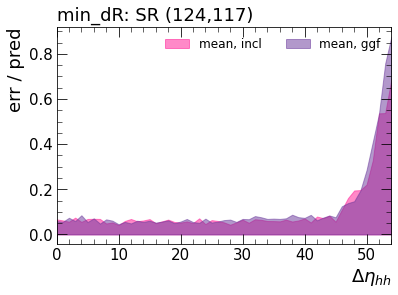

<ipython-input-197-db1a026e493c>:9: RuntimeWarning: invalid value encountered in true_divide
  plt.fill_between(range(nb),hdict1[f'{c}_SR_std']/hdict1[f'{c}_SR_mean'],
<ipython-input-197-db1a026e493c>:11: RuntimeWarning: invalid value encountered in true_divide
  plt.fill_between(range(nb),hdict2[f'{c}_SR_std']/hdict2[f'{c}_SR_mean'],


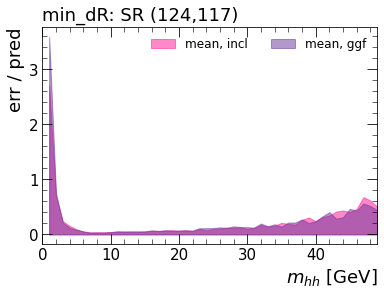

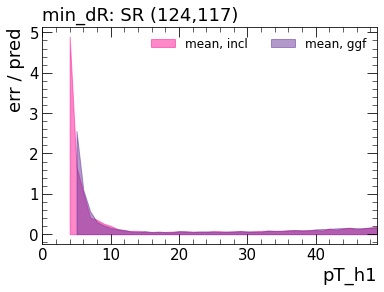

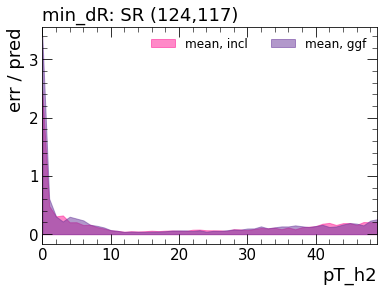

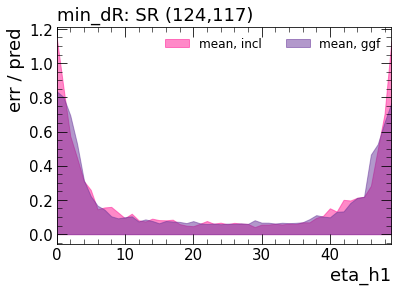

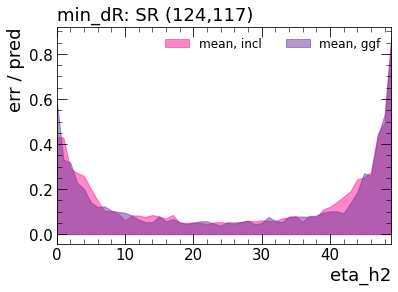

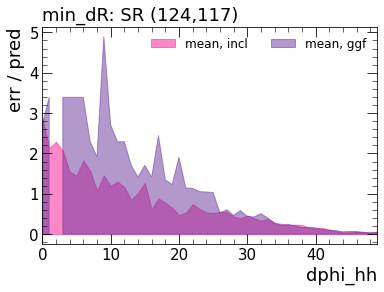

In [197]:
for c, nb, r, xl in zip(['dEta_hh','m_hh','pT_h1','pT_h2','eta_h1','eta_h2','dphi_hh'],
                        [55]+[50]*6,
                        [(0,1.65),(200,1200),(0, 400), (0, 400), (-3, 3), (-3, 3), (-0.5, np.pi)],
                        ['$\Delta \eta_{hh}$', '$m_{hh}$ [GeV]','pT_h1','pT_h2','eta_h1','eta_h2','dphi_hh']):

    plt.figure()
    
        
    plt.fill_between(range(nb),hdict1[f'{c}_SR_std']/hdict1[f'{c}_SR_mean'],
                     color='deeppink',label='mean, incl',lw=1,alpha=.5)   
    plt.fill_between(range(nb),hdict2[f'{c}_SR_std']/hdict2[f'{c}_SR_mean'],
                     color='rebeccapurple',label='mean, ggf',lw=1,alpha=.5)   

#     h_2b_1 = np.histogram(df.loc[df.X_hh < 1.6,c].values,nb, r)[0]
#     plt.errorbar(range(nb),
#                  np.nan_to_num(h_2b_1/hdict1[f'{c}_SR_mean']),
#                  np.nan_to_num(np.sqrt(h_2b_1)/hdict1[f'{c}_SR_mean']),
#                  color='deeppink',lw=0, 
#                  elinewidth=2,marker='.',label='1% 2b, incl',zorder=5)


#     h_2b_2 = np.histogram(df.loc[(df.X_hh < 1.6) & (~df.pass_vbf_sel),c].values, nb, r)[0]
#     plt.errorbar(range(nb),
#                  np.nan_to_num(h_2b_2/hdict2[f'{c}_SR_mean']),
#                  np.nan_to_num(np.sqrt(h_2b_2)/hdict2[f'{c}_SR_mean']),
#                  color='rebeccapurple',lw=0, 
#                  elinewidth=2,marker='.',label='1% 2b, ggf',zorder=5)

    plt.xlabel(xl,x=1,ha='right',fontsize=18)
    plt.ylabel('err / pred',y=1,ha='right',fontsize=18)
    plt.title(f'min_dR: SR ({x},{y})',x=0,loc='left')

    plt.legend(ncol=2,fontsize=12)
    plt.xlim(0,nb-1)
    #plt.savefig(f'{figDir}/m_hh_cats_{nSeeds}seeds.pdf',bbox_inches='tight')
    plt.show()

### Step 2: Load in the rewieghting

In [ ]:
rwCols = ['event_number', 'pass_vbf_sel', 'ntag', 'njets', 'X_hh', 'kinematic_region',
          'm_hh', 'pt_hh', 'dEta_hh', 'X_wt_tag', 
          'm_h1', 'pT_h1', 'eta_h1', 'phi_h1',
          'm_h2', 'pT_h2', 'eta_h2', 'phi_h2',
          'SR_varName','CVR', 'kinematic_region_Q', 'sr_bin', 'SRout',
          f'NN_d24_weight_bstrap_med_{yr}',
          f'NN_d24_weight_bstrap_IQR_{yr}',
          'rw_to_4b',
          f'NN_d24_weight_VRderiv_bstrap_med_{yr}',
          f'NN_d24_weight_VRderiv_bstrap_IQR_{yr}']

In [ ]:
# rwDir = '../data/RR/cryptotuples/ttbar/quads/rw_pre_Xwt/'

# with uproot.open(f'{rwDir}/data{yr}_Xhh_45_NN_100_bootstraps.root') as f:
#     rw = f['sig'].arrays(rwCols,library='pd')
#     norm     = f['NN_norm_bstrap_med_17'].all_members['fVal']
#     norm_VR  = f['NN_norm_bstrap_med_17'].all_members['fVal']
#     norm_IQR = f['NN_norm_bstrap_med_17'].all_members['fVal']